# Loan Amount Optimization with a **_Hybrid Model_**

Here, we will be trying to predict the most optimal loan amount to lend to a person using two approaches: classification and regression, as well as their combination, using the [Lending Club dataset](https://www.kaggle.com/wordsforthewise/lending-club).

## Data Acquisition

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt

from sklearn.decomposition import PCA
from sklearn.preprocessing import scale, minmax_scale, StandardScaler
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC, SVR
from sklearn.linear_model import Ridge, RidgeCV, LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, precision_score, recall_score, accuracy_score, r2_score, \
    mean_squared_error, explained_variance_score, classification_report, make_scorer
from sklearn.pipeline import Pipeline
from scipy.optimize import minimize

For the purposes of building a simple model (and because my computer is incapable of processing the entire dataset), we can take just a slice of the datasets to work with. To make sure that our slice is representative, we can sample the datapoints randomly using the parameter `skiprows` parameter in pandas' `read_csv()` which we can configure using the helper function below to skip a row with a given probability. For now, we can set that probability to 99% (i.e., we would preserver 1% of the data, or about 22,000 datapoints in the accept dataset).

In [2]:
file_acc = r"C:\Users\breedoon\Downloads\accepted_2007_to_2018Q4.csv"
file_rej = r"C:\Users\breedoon\Downloads\rejected_2007_to_2018Q4.csv"

np.random.seed(849)

def get_row_skipper(preserve=0.5):
    """
    Returns a callable that receives a row number and returns whether it should be skipped.

    :param preserve: a probability for any row (except row 0) to not be skipped
    :return: True if the row should be skipped or False otherwise
    """

    def skip_random_rows(row_idx):
        if row_idx == 0:
            return False  # do not skip the header
        return np.random.random() >= preserve

    return skip_random_rows


In [3]:
df_raw_acc = pd.read_csv(file_acc, skiprows=get_row_skipper(preserve=0.01))
df_raw_rej = pd.read_csv(file_rej, skiprows=get_row_skipper(preserve=0.01))

c:\users\breedoon\appdata\local\programs\python\python38-32\lib\site-packages\IPython\core\interactiveshell.py:3145: DtypeWarning: Columns (0,19,118) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


## Modeling

### Classification of loan approval

We can start by building a classification model that, for any given applicant, would decide whether that applicant is eligible for a loan (i.e., whether we should classify him as accepted or rejected).

#### Preparing the data

In [4]:
shared_columns = ['loan_amnt', 'fico_range_low', 'dti', 'emp_length', 'addr_state']
rej_to_acc_cols = {
    'Amount Requested': 'loan_amnt',
    'Application Date': 'date',  # used only to convert vantage scores to fico
    'Risk_Score': 'fico_range_low',  # better to underestimates people's creditworthiness
    'Debt-To-Income Ratio': 'dti',
    'Employment Length': 'emp_length',
    'State': 'addr_state',
}

df_classif_rej = df_raw_rej.rename(rej_to_acc_cols, axis=1)
df_classif_acc = df_raw_acc[shared_columns].copy()

From the documentation of the reject dataset, we can see that the metric for 'Risk_Score' has changed on Nov 5th, 2013 from FICO to Vantage score, which are not exactly equivalent. So, for consistency, given the fact that accept database contains only FICO scores, we should convert all of the scores to FICO using a simplified [formula](https://www.credit-report-101.com/credit-report-archive/convert-vantage-fico/): FICO = (Vantagescore – 501) * 1.12 + 300.

In [5]:
# convert from vantage to fico for consistency based on the formula from:
# https://www.credit-report-101.com/credit-report-archive/convert-vantage-fico/

date_of_switch_from_fico_to_vantage = dt(2013, 11, 5)

rows_with_vantage_mask = pd.to_datetime(df_classif_rej['date']) >= date_of_switch_from_fico_to_vantage
df_classif_rej.loc[rows_with_vantage_mask, 'fico_range_low'] = (df_classif_rej[rows_with_vantage_mask]['fico_range_low']
                                                                - 501) * 1.12 + 300

df_classif_rej.drop('date', axis=1, inplace=True)

Then, we need to convert the reject DTI values into the same number format as the accept dataset (e.g., '55%' -> '55'):

In [6]:
df_classif_rej.loc[:, 'dti'] = df_classif_rej['dti'].str.replace('%', '').astype('float64')

Now we can combine the two datasets into one, and finish the remaining steps of preparing the data for the combined dataset.

Also, since our goal is to ensure the person in question is actually eligible for the loan, we should mark as rejected those people who were initially accepted but ended up not being able to pay off the loan.

In [7]:
# adding the label
df_classif_acc['accepted'] = True
df_classif_rej['accepted'] = False

# unmark those who were accepted but defaulted as rejected
df_classif_acc.loc[df_raw_acc['loan_status'] == 'Default', 'accepted'] = False

shared_columns.append('accepted')
df_classif_combined = pd.concat([df_classif_acc[shared_columns], df_classif_rej[shared_columns]], ignore_index=True)


And finally, we need to convert the employment length into a numeric variable:

In [8]:
def emp_length_to_number(emp_length: pd.Series):
    """
    Converts employment length of format 'n years' column to numbers.
    >>> emp_length_to_number(pd.Series(['< 1 year', '1 year', '5 years', '10 years', '10+ years']))
    pd.Series([0.0, 1.0, 5.0, 10.0, 11.0], dtype='float64')
    """
    return (emp_length  # bring all to the same format of 'n years'
            .replace('< 1 year', '0 years').replace('1 year', '1 years').replace('10+ years', '11 years')
            .str[:-6]  # remove the 'years' part
            .astype('float64'))  # convert to float to preserve nans


In [9]:
df_classif_combined.loc[:, 'emp_length'] = emp_length_to_number(df_classif_combined['emp_length'])

In [10]:
df_classif_combined.dropna(inplace=True)

In [11]:
columns_classif = ['loan_amnt', 'fico_range_low', 'dti', 'emp_length']

x = df_classif_combined[columns_classif]
y = df_classif_combined['accepted']

seed = 56061
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=seed)

#### Model Selection

##### Choosing the model type and its parameters

To choose the right model and make sure it does not overfit, we can run a standard 5-fold cross-validation on 3 popular classification models: KNN, Random Forest, and Logistic Regression, and choose the one that obtains the highest score across all 5 folds.

There are multiple metrics that would help us score the candidate models, and to choose one we need to consider the context of the application of our model. In our case, representing the loan sponsor, we would be far more sensitive to false positives than to false negatives (i.e., we would rather underfund somebody than give somebody a loan they won't pay back), which means that the more appropriate metric for us to use would be precision.

In [12]:
classifiers = [
    KNeighborsClassifier, RandomForestClassifier, LogisticRegression
]

param_grids = [
    dict(n_neighbors=[1, 5, 10, 50]),
    dict(n_estimators=[10, 50, 100, 300],
         max_depth=[3, 10, None],
         max_features=['auto', 'sqrt']),
    dict(C=[0.01, 0.1, 1, 10, 100])
]

In [13]:
best_params = []
best_scores = []

for i in range(len(classifiers)):
    print(f'Training {classifiers[i].__name__}...')
    model = classifiers[i]()

    grid_search = GridSearchCV(model, n_jobs=-1, param_grid=param_grids[i], verbose=5,
                               scoring=make_scorer(precision_score))
    grid_search.fit(x_train, y_train)

    best_params.append(grid_search.best_params_)
    best_scores.append(grid_search.best_score_)

    print(classifiers[i].__name__)
    print('Best params:', grid_search.best_params_)
    print('Best score:', grid_search.best_score_, end='\n\n')

Training KNeighborsClassifier...
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:    9.5s remaining:    9.5s
[Parallel(n_jobs=-1)]: Done  15 out of  20 | elapsed:    9.8s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   12.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   12.2s finished


KNeighborsClassifier
Best params: {'n_neighbors': 1}
Best score: 0.8665328683049708

Training RandomForestClassifier...
Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   48.3s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  2.6min finished


RandomForestClassifier
Best params: {'max_depth': None, 'max_features': 'auto', 'n_estimators': 10}
Best score: 0.9280195213948943

Training LogisticRegression...
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  16 out of  25 | elapsed:    5.0s remaining:    2.8s
[Parallel(n_jobs=-1)]: Done  22 out of  25 | elapsed:    6.2s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    6.8s finished


LogisticRegression
Best params: {'C': 0.1}
Best score: 0.8398147906364054



c:\users\breedoon\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [14]:
best_idx = max(range(len(classifiers)), key=lambda i: best_scores[i])
model_classif = classifiers[best_idx](**best_params[best_idx]).fit(x_train, y_train)
y_pred = model_classif.predict(x_test)

print(f'Best classifier: {classifiers[best_idx].__name__}')
print('Precision:', f"{precision_score(y_test, y_pred)}", end='\n\n')


Best classifier: RandomForestClassifier
Precision: 0.9298054191671213



##### Picking a confidence threshold

After having picked the best model parameters that give us the highest precision at the standard confidence threshold of 0.5, we might try to manipulate this threshold to see if we can get better values and whether it would be worth it.

In [15]:
def filled_confusion_matrix(y_true, y_pred, classes=(False, True), normalize=False):
    conf_m = confusion_matrix(y_true, y_pred)
    if normalize:
        conf_m = conf_m / conf_m.sum()
    return pd.DataFrame(conf_m,
                        index=pd.Series(classes, name='True'),
                        columns=pd.Series(classes, name='Pred'))


def get_proba_predictions(model, x, threshold=0.5):
    """
    Returns predictions of the given sklearn model based on the threshold of the prediction probability
    """
    return model.predict_proba(x).transpose()[1] >= threshold


def get_threshold_scores(model, x_test, y_test, scorers=(precision_score, recall_score, f1_score, accuracy_score),
                         min_thr=0.1, max_thr=0.5, step=0.1):
    """
    Iterates through all possible thresholds and returns their respective accuracies within the model
    :return:  tuple of (thresholds, scores)
    """
    thresholds = np.arange(min_thr, max_thr + step, step)
    scores = []

    y_pred_proba = model.predict_proba(x_test).transpose()[1]

    for scorer in scorers:
        scorer_scores = []
        for threshold in thresholds:
            y_pred = y_pred_proba >= threshold
            scorer_scores.append(scorer(y_test, y_pred))
        scores.append(scorer_scores)
    return thresholds, np.array(scores)


def find_best_thresholds(model, x_test, y_test, **kwargs):
    thresholds, scores = get_threshold_scores(model, x_test, y_test, **kwargs)
    max_inds = scores.argmax(axis=1)
    return thresholds[max_inds], scores.max(axis=1)


def plot_thresholds(model, x_test, y_test, scorers=(precision_score, recall_score, f1_score, accuracy_score), **kwargs):
    thresholds, scores = get_threshold_scores(model, x_test, y_test, scorers=scorers, **kwargs)
    for i in range(len(scorers)):
        plt.plot(thresholds, scores[i], label=scorers[i].__name__)
    plt.title('Score depending on the threshold of ' + type(model).__name__)
    plt.legend()
    plt.grid()

    plt.xlabel('Confidence threshold')
    plt.ylabel('Score')

    plt.show()


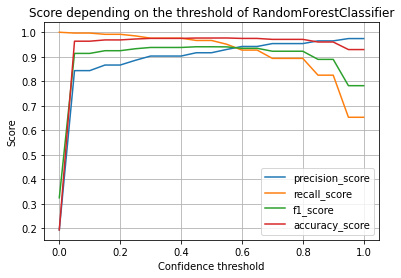

In [16]:
plot_thresholds(model_classif, x_test, y_test, min_thr=0, max_thr=1, step=0.05)

As we can see from the graph, precision tends upward as the threshold increases reaching almost 100%. However, we can also see that recall follows a downward trend (as expected) and sees the greatest falls between the thresholds of about 0.9 and 0.95 where it drops from over 0.8 to about 0.65 while precision only barely increases. A smaller drop occurs around the threshold of 0.8, and an even smaller one around 0.6. So, we can take a closer look at the confusion matrices at those thresholds to make a final decision about them. 

First, for comparison, we can look at the default confusion matrix with a threshold of 0.5:

In [17]:
threshold = 0.5
y_pred = get_proba_predictions(model_classif, x_test, threshold)
filled_confusion_matrix(y_test, y_pred, ['Rej', 'Acc'], normalize=True)

Pred,Rej,Acc
True,,
Rej,0.788892,0.017105
Acc,0.006496,0.187507


In [18]:
threshold = 0.6
y_pred = get_proba_predictions(model_classif, x_test, threshold)
filled_confusion_matrix(y_test, y_pred, ['Rej', 'Acc'], normalize=True)

Pred,Rej,Acc
True,,
Rej,0.792068,0.013929
Acc,0.009491,0.184512


In [19]:
threshold = 0.8
y_pred = get_proba_predictions(model_classif, x_test, threshold)
filled_confusion_matrix(y_test, y_pred, ['Rej', 'Acc'], normalize=True)

Pred,Rej,Acc
True,,
Rej,0.797589,0.008408
Acc,0.020678,0.173325


In [20]:
threshold = 0.9
y_pred = get_proba_predictions(model_classif, x_test, threshold)
filled_confusion_matrix(y_test, y_pred, ['Rej', 'Acc'], normalize=True)

Pred,Rej,Acc
True,,
Rej,0.800152,0.005846
Acc,0.033958,0.160045


In [21]:
threshold = 0.95
y_pred = get_proba_predictions(model_classif, x_test, threshold)
filled_confusion_matrix(y_test, y_pred, ['Rej', 'Acc'], normalize=True)

Pred,Rej,Acc
True,,
Rej,0.802642,0.003356
Acc,0.067266,0.126737


As we can see, with the default threshold of 0.5, our model advises us to fund an uncreditworthy person 1.7% of the time while it tells us to reject a person who could've been funded 0.6% of the time, leaving us with 18% of people who were correctly classified as creditworthy and whom we would fund. On the other end of the spectrum, a threshold of 0.95 significantly reduces the  chances of funding uncreditworthy people to 0.3% but leaves us with just 12% of those to fund with the remaining 6% being mistakenly marked as uncreditworhy. The remaining thresholds provide us with several intermediate values which in practice would be chosen based on risk aversion of the sponsor, but for our purposes we can pick a threshold of 0.8, which halves the number of false positives to 0.8% while keeping the number of true positives at a relatively high 17%.

## Regression model of loan amount

Now, after we potentially filtered out the ineligible applicants, we can focus on determining the optimal value of the loan that an applicant should receive. Given we're working with alread accepted applicants

### Preparing the data

In [22]:
known_columns = ['addr_state', 'annual_inc', 'annual_inc_joint', 'application_type', 'dti', 'dti_joint', 'emp_length',
                 'fico_range_high', 'fico_range_low', 'home_ownership', 'loan_amnt', 'purpose']
df_regr = df_raw_acc[known_columns].copy()

As we can see, some of the columns are related to joint loan applications, which, ideally, would require building a separate model, but in this case, we might want to check if these applications comprise a significant portion of the application pool for us to care about it, and if they don't, we might just get rid of them for the sake of simplicity.

In [23]:
df_regr.groupby('application_type')['application_type'].count() / len(df_regr)

application_type
Individual    0.945637
Joint App     0.054319
Name: application_type, dtype: float64

As we can see, about 95% of all applications are non-joint so we won't lose much by getting rid of them entirely.

In [24]:
df_regr.drop(['annual_inc_joint', 'application_type', 'dti_joint'], axis=1, inplace=True)

Then, we, similarly, we need to convert the employment length into a number:

In [25]:
df_regr.loc[:, 'emp_length'] = emp_length_to_number(df_regr['emp_length'])
df_regr.dropna(inplace=True)

Now, we have a few categorical variables which we would need to convert to dummy variables in order to use in a regression model:

In [26]:
categorical_cols = ['addr_state', 'home_ownership', 'purpose']
dummies = pd.get_dummies(df_regr[categorical_cols])
df_regr.loc[:, dummies.columns] = dummies

In [27]:
columns_regr = ['annual_inc', 'dti', 'emp_length', 'fico_range_low']
y_col = 'loan_amnt'
x_cols = columns_regr + dummies.columns.tolist()

y = df_regr[y_col]
x = df_regr[x_cols]

seed = 38429
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=seed)

To normalize our data to be easily applied in regression models, we should preprocess it to having the same means and variances:

In [28]:
x_scaler = StandardScaler().fit(x_train)
x_train = x_scaler.transform(x_train)

### Model selection

We can try a few models to perform this regression task, a Ridge Linear Regression, and a Random Forest.

In [29]:
def get_y_pred_preprocessed(model, x_test, x_scaler=x_scaler):
    return model.predict(x_scaler.transform(x_test))

In [30]:
model = RidgeCV(alphas=[0.01, 0.1, 1, 10, 100])
model.fit(x_train, y_train)

y_pred = get_y_pred_preprocessed(model, x_test, x_scaler)
explained_variance_score(y_test, y_pred)

0.012050022536270966

In [31]:
model = RandomForestRegressor()

grid_search = GridSearchCV(model, n_jobs=-1, param_grid=param_grids[1])
grid_search.fit(x_train, y_train)

print('Best params:', grid_search.best_params_)
print('Best score:', grid_search.best_score_, end='\n\n')

Best params: {'max_depth': 10, 'max_features': 'auto', 'n_estimators': 300}
Best score: 0.2835250978305646



In [32]:
model_regr = RandomForestRegressor(**grid_search.best_params_)

model_regr.fit(x_train, y_train)

y_pred = get_y_pred_preprocessed(model_regr, x_test, x_scaler)
explained_variance_score(y_test, y_pred)

0.2964294106759592

### Model evaluation

Since our model is a random forest, we can take a look at which features turned out to be the most important at determining the loan amount:

In [33]:
pd.DataFrame([x.columns, model_regr.feature_importances_],
             index=['Feature', 'Gini importance']
             ).transpose().sort_values('Gini importance', ascending=False)

,Feature,Gini importance
0,annual_inc,0.551323
1,dti,0.141947
3,fico_range_low,0.071503
61,purpose_debt_consolidation,0.0277434
2,emp_length,0.0276849
...,...,...
69,purpose_renewable_energy,5.21108e-05
72,purpose_wedding,3.80022e-05
62,purpose_educational,4.08229e-07
56,home_ownership_OTHER,3.84706e-09


We can also look at the residuals of our model, and how they depend on the true loan amount

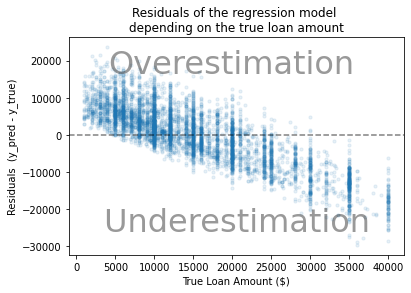

In [299]:
residuals = y_pred - y_test

plt.scatter(y_test, residuals, s=10, alpha=0.1, label='True')
plt.xlabel('True Loan Amount ($)')
plt.ylabel('Residuals  (y_pred - y_true)')
plt.title('Residuals of the regression model \ndepending on the true loan amount')

plt.axhline(0, ls='--', c='k', alpha=0.5)
plt.annotate('Overestimation', xy=(y_pred.max() / 1.75, residuals.max() / 1.25), size=32, color='k', alpha=0.4,
                ha='center', va='center')
plt.annotate(' Underestimation', xy=(y_pred.max() / 1.75, residuals.min() + residuals.max() / 4), size=32, color='k', alpha=0.4,
                ha='center', va='center')
plt.show()

## Combining the Models

As we can see, our regression model can be off by over $10,000 which can be decisive in accepting or rejecting somebody's loan application, while our classification model is pretty precise in determining whether an application with a given loan amount would be accepted. Given that, we can leverage the high performance of our classification model to correct the predictions made by the regression model, i.e., if a person with a predicted loan amount was classified as accepted we would bump up that amount to find a value beyond which he is no longer accepted (to correct for regression model's underestimation), or if that person was classified as rejected with that amount, we can bump it down
until (or if) that person is accepted (to correct for overestimation).

Ideally, we wouldn't even need to have a regression model and instead we could just start from $0 and keep increasing the loan amount for each application until we hit the ceiling and use that value as our prediction. However, our classification model might mistakenly always give acceptance to some people no matter the loan amount simply because it was not trained on anyone requesting a million-dollar loan (which is particularly true of random forests, compared to, for example, logistic regression which would have coefficients generalizable beyond the training data). So, in a case where our model does give acceptance to a person no matter how insanely high the requested loan amount is, we would indeed have to use on the initial prediction of our regression model to return as our final prediction. 

Relying on the less accurate regression model does seem to involve more risk of lending a person more money than they can pay back, but, as we can see from the residuals graph, the regression model tends to underestimate for higher loan amounts which should potentially decrease the total monetary loss resulting from this inaccuracy. As for the lower loan amounts where the model tend to overestimate, this risk is only relevant if our classification model mistakenly classified the ineligible applicant as eligible, which happens only 5% of the time (with the threshold of 0.8). In most other cases, if the regression model overestimated, the classification model would spot that and we would bring down the loan amount to the level approved by the classification model.

### Final Product

Now, we can combine our two models under a single function, as well as add the functions that would perform the optimization procedure of the loan amount as discussed above:

In [384]:
IMPOSSIBLE_LOAN_AMT = 1e9  # used to verify that the model won't always give acceptance
MAX_LOAN_AMT = 100_000_000  # maximum laon amount (will not increase beyond that even if a person is classified as accepted)


def optimize_loan_amt_single(loaner, threshold=0.5):
    """
    Uses scipy optimization to find the highest possible loan amount for the given applicant to be approved.
    :param loaner: a list (or Series) of 4 (preprocessed) application values: loan_amnt, fico_range_low, dti, emp_length
    :param threshold: a confidence threshold for the classification model of loan approval
    :return: loaner data with updated loan_amnt
    """
    loaner_no_amnt = loaner.drop('loan_amnt').copy()

    # Objective function that returns either the given loan amt if approved or 0 otherwise
    obj_function = lambda loan_amnt: -loan_amnt * get_proba_predictions(
        model_classif, [loaner_no_amnt.append(pd.Series(dict(loan_amnt=loan_amnt)))[columns_classif]], threshold)

    loaner['loan_amnt'] = minimize(obj_function, [loaner['loan_amnt']],
                                   method='TNC', bounds=[(0, MAX_LOAN_AMT)]).x[0]

    return loaner


def optimize_loan_amts(loaners: pd.DataFrame, threshold=0.5):
    loaners_copy = loaners.copy()
    
    # Get acceptance with initial loan amounts
    loaners_copy.dropna(subset=columns_classif, inplace=True)
    initial_accepted = get_proba_predictions(model_classif, loaners_copy[columns_classif], threshold)

    # To check if model has an upper boundary and won't give acceptance no matter what  (all should be False)
    loaners_copy['loan_amnt'] = IMPOSSIBLE_LOAN_AMT
    new_accepted_high = get_proba_predictions(model_classif, loaners_copy[columns_classif], threshold)
    
    # To check if people who weren't accepted with non-zero amounts would be accepted with for loan of 0
    new_accepted_low = get_proba_predictions(model_classif, loaners[columns_classif], threshold)
    
    # Was True but became False with a large loan amount (i.e., we can push the current amount up) 
    # or was Fasle but becamse True with $0 (i.e., we can lower the amount to gain acceptance)
    mask_optimizable = (initial_accepted > new_accepted_high) | (initial_accepted < new_accepted_low & ~new_accepted_high)
    loaners.loc[mask_optimizable] = loaners[mask_optimizable].apply(
        lambda loaner: optimize_loan_amt_single(loaner, threshold), axis=1)
    return loaners


def find_max_loan_amt(loaners: pd.DataFrame, threshold=0.5, reject_as_0=True, maximize=False):
    """
    :param loaners: dataframe in format of the accept dataset;
    must contain the following columns:
    annual_incm, dti, emp_length, fico_range_low, addr_state, home_ownership, purpose
    :param threshold: a confidence threshold to be given to the classification model
    to make a decision on whether any given person should be funded.
    :param reject_as_0: wheather set the loan amount to 0 for those who are classified as rejected.
    :param maximize: whether an optimization technique should be applied to find the highers possible loan amount
     for each eligible applicant (takes time).

    :returns: a dataframe with the feature columns (above) plus a loan_amnt column
    containing either 0 (if loan was not approved) or the value of the loan in dollars.
    """
    x_test = loaners.copy()

    new_dummies = pd.get_dummies(x_test[categorical_cols])

    # Drop dummy values that didn't exist in training set
    new_dummies.drop(set(new_dummies.columns) - set(dummies.columns), axis=1, inplace=True)

    # Set dummy values that exist in training set but not in `loaners` to 0`
    new_dummies[list(set(dummies.columns) - set(new_dummies.columns))] = 0

    x_test[new_dummies.columns] = new_dummies

    x_test['emp_length'] = emp_length_to_number(x_test['emp_length'])

    x_test.dropna(subset=x_cols, inplace=True)

    x_test['loan_amnt'] = get_y_pred_preprocessed(model_regr, x_test[x_cols])

    if reject_as_0:
        x_test.dropna(subset=columns_classif, inplace=True)
        accept = get_proba_predictions(model_classif, x_test[columns_classif], threshold)

        # Set loan amount of those who should not be accepted to 0
        x_test.loc[~accept, 'loan_amnt'] = 0

    if maximize:
        x_test = optimize_loan_amts(x_test, threshold)

    return x_test[columns_regr + categorical_cols + ['loan_amnt']]


We can test this approach by taking another 1% sample from our accepted dataset. The sampling is technically with replacement, so there can be some datapoints that the model has already seen, but given that both of the sets comprise about 1% of the full datasets, the number of such datapoints should be insignificant. In any case, we would look at this subset only for the purposes of demonstration

In [385]:
loaners_test = pd.read_csv(file_acc, skiprows=get_row_skipper(preserve=0.01))

c:\users\breedoon\appdata\local\programs\python\python38-32\lib\site-packages\IPython\core\interactiveshell.py:3145: DtypeWarning: Columns (0,19,118) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [400]:
loaners_res = find_max_loan_amt(loaners_test, threshold=0.8)

loaners_res.head()

,annual_inc,dti,emp_length,fico_range_low,addr_state,home_ownership,purpose,loan_amnt
0,55000.0,5.91,11.0,675.0,PA,MORTGAGE,debt_consolidation,10718.401611
1,97000.0,22.22,11.0,710.0,NY,OWN,major_purchase,15584.004647
2,38000.0,25.36,3.0,660.0,KS,RENT,debt_consolidation,10814.264527
3,120000.0,18.32,11.0,705.0,MI,MORTGAGE,debt_consolidation,22405.470009
4,134000.0,26.05,0.0,680.0,MI,RENT,debt_consolidation,23693.710970


To simplify calculations for a single person to get a better grasp at knowing what our model is doing, we can create a wrapper function that would output the targeted loan amount for a given person:

In [387]:
def get_single_loan_prediction(annual_inc, fico, dti, emp_length, addr_state, home_ownership, purpose,
                               threshold=0.8, reject_as_0=True, maximize=True):
    """
    Finds the optimal amount of money to be loaned to the applicant given the information provided in their application.

    :param annual_inc: Annual income in dollars of the applicant
    :param fico: FICO score of the applicant
    :param dti: Debt to income ration (in %) of the applicant
    :param emp_length: number of years employed, one of '< 1 year', '1 year', '2 years', ... '10 years', '10+ years'
    :param addr_state: home state address of the applicant
    :param home_ownership: one of 'MORTGAGE', 'RENT', 'OWN', 'ANY', 'NONE'
    :param purpose: one of  'debt_consolidation', 'credit_card', 'home_improvement', 'other',
                            'car', 'major_purchase', 'medical', 'small_business', 'moving',
                            'vacation', 'house', 'renewable_energy', 'wedding', 'educational'
    :param threshold: a confidence threshold of whether the applicant is creditworthy.
    The higher the value, the more likely the applicant is to get rejected.
    :returns: amount of money in dollars to be given to the applicant (or 0 if their application should be rejected)
    """
    return find_max_loan_amt(pd.DataFrame(dict(
        annual_inc=annual_inc,
        fico_range_low=fico,
        dti=float(dti.replace('%', '')),  # remove the %
        emp_length=emp_length,
        addr_state=addr_state,
        home_ownership=home_ownership,
        purpose=purpose,
    ), index=[0]), threshold=threshold, reject_as_0=reject_as_0, maximize=maximize).loc[0, 'loan_amnt']

### Usage Example

Let's see how our algorithms works on a random person from Washington with an income of $60,000, a high FICO score, low DTI, renting a home, and asking for a loan for his small business:

In [388]:
person = dict(
    annual_inc=60000,
    fico=770,
    dti='2%',
    emp_length='3 years',
    addr_state='WA',
    home_ownership='RENT',
    purpose='small_business'
)
get_single_loan_prediction(**person, maximize=False)

13525.644821904627

How would the loan amount change if that person was in California?

In [389]:
get_single_loan_prediction(**{**person, 'addr_state': 'CA'}, maximize=False)

14151.674207566513

What would the loan be if his income was $90,000?

In [390]:
get_single_loan_prediction(**{**person, 'annual_inc': 90000}, maximize=False)

23974.33030917688

What is the maximum possible amount of money we can borrow to that person?

In [391]:
get_single_loan_prediction(**person, maximize=True)

28900.000943407416

Now, what would happed to the loan amount if the DTI was much higher and fico was much lower, but also income was much higher and employment length was much higher?

In [392]:
person = {**person, 
                  'dti': '20%', 
                  'fico': 705, 
                  'annual_inc': 125000, 
                  'emp_length': '10+ years'}
get_single_loan_prediction(**person, maximize=False)

0.0

We can also look at what loan amount our regression model assigned to that person for which he wasn't approved:

In [393]:
get_single_loan_prediction(**person, reject_as_0=False, maximize=False)

22137.707090962063

And we can also try to find a lower amount for which he would be approved:

In [394]:
get_single_loan_prediction(**person, maximize=True)

19875.000862143934

### Conclusion

Both models have their advantages and disadvantages: the classification model is very accurate (Precision = 0.95) but can approve a person with unreasonably high loan amount, while the regression model is not very accurate ($R^2 = 0.28$) but gives does give a reasonable single number, and the combination of these models managed to combine the benefits of both of them while minimizing their downsides.